# Introduction + Set-up

Machine learning has a phenomenal range of application in the health sciences. This tutorial will go over the complete pipeline to build a model that can determine the dementia level of an Alzheimer's patient from their MRI image. This model achieves an a high ROC AUC score.

This tutorial highlights the ease of building a CNN using `tf.keras`. Additionally, TensorFlow 2.3 has new features, including easy data loading utilities that were previously not available in TensorFlow 2.2. We'll be seeing how easy data loading is with these additional features.

We'll be using a GPU accelerator for this NB.

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import kaggledatasets
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil
from PIL import Image
from glob import glob
from os.path import join
from sklearn.metrics import confusion_matrix, classification_report
import itertools
from tqdm import tqdm


try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

Number of replicas: 1
2.14.0


It's always a good idea to set constant variables instead of hard coding numbers into your code. It saves time later when you want to change certain parameters.
NEW FRO CHIARA : I CHANGED THE IMAGE SIZE (BECAME 128 X128) AND NUMBER OF EPOCHS FROM 100 TO 50

In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * strategy.num_replicas_in_sync  #original was 16
IMAGE_SIZE = [128, 128]  
EPOCHS = 50  #original was 100

# Data Loading

We'll be using a [Kaggle Alzheimer's dataset](https://www.kaggle.com/tourist55/alzheimers-dataset-4-class-of-images) for our tutorial. `tf.keras` has a new preprocessing function that can easily load in images for a directory. In order for this function to work, the data has to be structured in a file directory format.

```
main_directory/
    class1/
        class1_images
    class2/
        class2_images
```

If you input the `main_directory` into the `tf.keras` function, it will figure out the rest!
In our case, the `train` directory is our main directory.

We are also specifying a 80:20 split for our training and validation datasets. To learn more about the importance of having a validation split, check out this [lesson](https://developers.google.com/machine-learning/crash-course/validation/another-partition) from Google's Machine Learning Crash Course.


NEW DATA: Alzheimer MRI Preprocessed Dataset (128 x 128)

The Data is collected from several websites/hospitals/public repositories.
The Dataset is consists of Preprocessed MRI (Magnetic Resonance Imaging) Images.
All the images are resized into 128 x 128 pixels.
The Dataset has four classes of images.
The Dataset is consists of total 6400 MRI images.
Class - 1: Mild Demented (896 images)
Class - 2: Moderate Demented (64 images)
Class - 3: Non Demented (3200 images)
Class - 4: Very Mild Demented (2240 images)
Motive
The main motive behind sharing this dataset is to design/develop an accurate framework or architecture for the classification of Alzheimers Disease


CHANGE FROM: WE CREATED TRAIN AND TEST FOLDERS RESPECTING THE PROPORTION AMONG CLASSES
FOLDERS ARE CREATED ( AND FILES ARE MOVED) ONLY IF NOT PRESENT (AND IF NOT ALREADY MOVED): THE CODE, IF RUN MULTIPLE TIMES, DOES THIS ONLY ONCE

We'll be renaming the class names and specifying the number of classes. In this case, we have 4 classes of dementia.

In [4]:
# TO KEEP THE ORIGINAL PREFETCH FORMAT  AND USE KERAS PREPROCESSING FUNCTION,
# STRUCTURE DATA IN THE PROPER DIRECTORY FORMAT: PUT YOUR PATH OF THE DATASET

dataset_path = r"C:/Users/Utente/Documents/UNIVERSITA_ANNO_5/DEEP_LEARNING/GROUP_PROJECT/Deep-Learning-project/.vscode/Deep-Learning-project-1/archive/Dataset/"
test_size=0.2
train_path=dataset_path+"/train/" #folder doesn’t exist yet
test_path=dataset_path+"/test/"  
classes = os.listdir(dataset_path)
print(classes)  # if train / test folders not created (first time running code), 'test' and  'train' not present

# Create folders (if not present) for test and training set
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)
print(classes)


for class_name in classes:
    print(class_name)
    class_path = os.path.join(dataset_path, class_name)
    train_class_path = os.path.join(train_path, class_name)  # train path containing one class
    test_class_path = os.path.join(test_path, class_name)  # test path containing one class


    #  Get the list of files in that class
    files = os.listdir(class_path)

    # Create a folder (inside training and test folder) for each class
    os.makedirs(train_class_path, exist_ok=True)
    os.makedirs(test_class_path, exist_ok=True)


    # Divide dataset of the class in training set and test set
    train_files, test_files = train_test_split(files, test_size=test_size, random_state=42)


    # Move training files (train_files) just created in the training folder
    for file in train_files:
        src_path = os.path.join(class_path, file).replace('\\','/')
        dst_path = os.path.join(train_path, class_name, file).replace('\\','/')
        if file not in dst_path:
           shutil.copyfile(src_path, dst_path)


    # Move test files (test_files) just created in the test folder
        src_path = os.path.join(class_path, file)
        dst_path = os.path.join(test_path, class_name, file)
        if file not in dst_path:
           shutil.copy(src_path, dst_path)


['MildDemented', 'ModerateDemented', 'NonDemented', 'test', 'train', 'VeryMildDemented']
['MildDemented', 'ModerateDemented', 'NonDemented', 'test', 'train', 'VeryMildDemented']
MildDemented
ModerateDemented
NonDemented
test
train
VeryMildDemented


In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "C:/Users/Utente/Documents/UNIVERSITA_ANNO_5/DEEP_LEARNING/GROUP_PROJECT/Deep-Learning-project/.vscode/Deep-Learning-project-1/archive/Dataset/train/",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "C:/Users/Utente/Documents/UNIVERSITA_ANNO_5/DEEP_LEARNING/GROUP_PROJECT/Deep-Learning-project/.vscode/Deep-Learning-project-1/archive/Dataset/train/",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,  
)



Found 5118 files belonging to 6 classes.
Using 4095 files for training.
Found 5118 files belonging to 6 classes.
Using 1023 files for validation.


ORIGINAL CODE: Change class names 

In [6]:
class_names = ['MildDementia', 'ModerateDementia', 'NonDementia', 'VeryMildDementia']
train_ds.class_names = class_names
val_ds.class_names = class_names

NUM_CLASSES = len(class_names)



Keep in mind that the choice of the test batch size depends on the characteristics of your data and the requirements of your evaluation process. The code you provided aims to find a reasonable batch size that is a divisor of ts_length and not greater than 80. If this meets your needs, then it should work for its intended purpose.

CHANGE-->Efficiency and Performance Optimization: In some cases, using a custom function for test data batch size can lead to more efficient data processing or better utilization of available resources, especially when dealing with unconventional data structures or sources.

#Visualize the data

Now that our data has been easily loaded in, the next step is to visualize our images. This helps us understand what is being used as an input for our model. It also serves as a check to see if our images have been loaded in correctly.

Write down number of samples for each class by counting  number of files for each folder
To do this, build a dictionary where  keys are folder names (-> the 4 classes) and values are the filenames for the files in each folder.

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
['VeryMildDemented', 'MildDemented', 'ModerateDemented', 'NonDemented']
VeryMildDemented class has 1791 samples
MildDemented class has 716 samples
ModerateDemented class has 51 samples
NonDemented class has 2560 samples


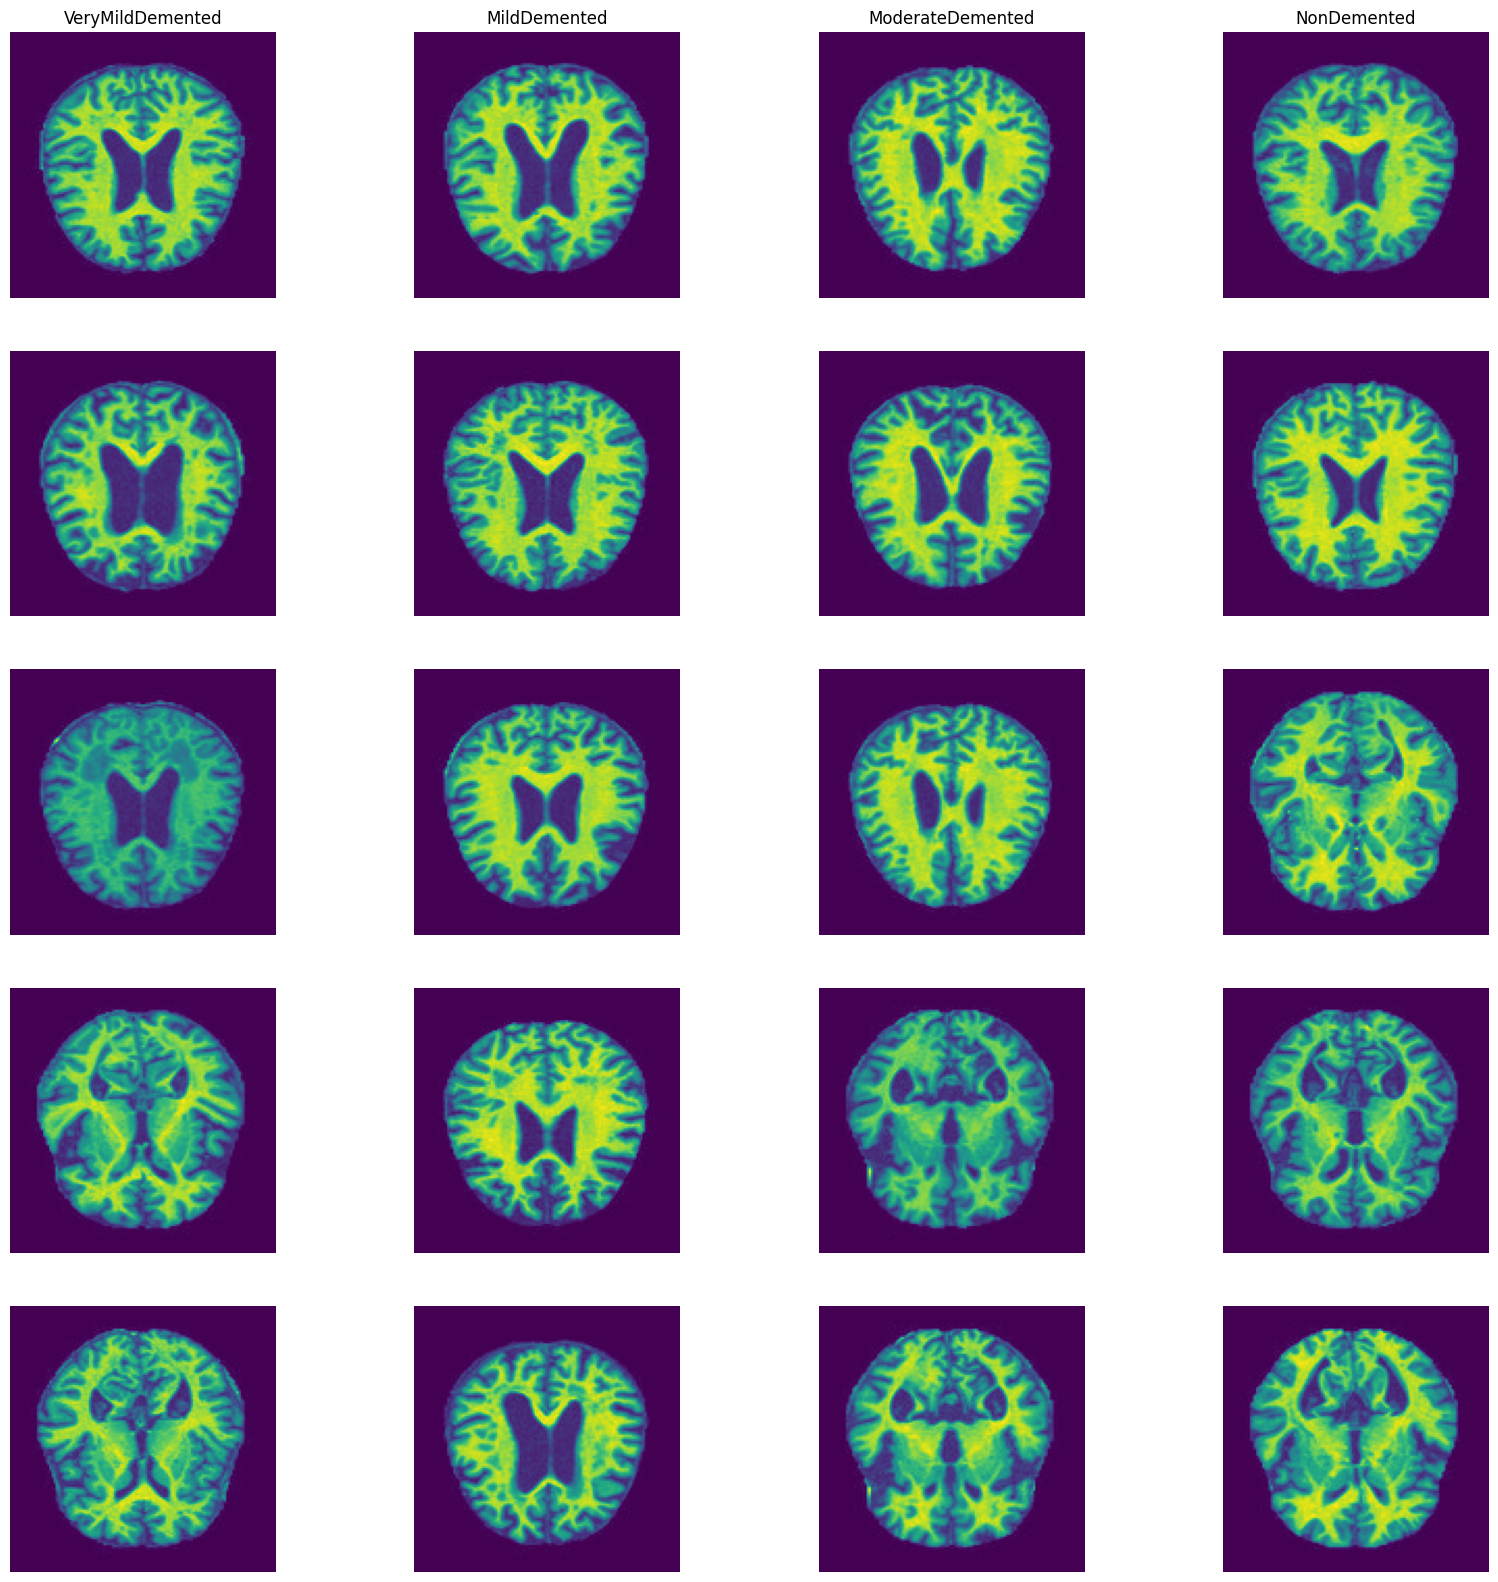

In [7]:
data_folder = train_path
classes = sorted([f for f in os.listdir(data_folder) if not f.startswith('.')])

classes.remove('test')
classes.remove('train')
print(classes)

classes.insert(0, classes.pop(3))  # ordered according to dementia (to plot them)
print(classes)

imgs = {c: glob(join(data_folder, c, "*")) for c in classes}
# - keys are folder names (-> the 4 classes)
# - values are the filenames for the files in each folder


for key in imgs.keys():
   print("{} class has {} samples".format(key,len(imgs[key])))

nrows=5

# CHANGE--> PLOT SOME (5) IMAGES PER CLASS ! TO SEE BETTER DIFFERENCES

fig, axs = plt.subplots(nrows=nrows, ncols=len(classes), figsize=(20, 20))

for i,(c,fnames) in enumerate(imgs.items()): # i is the count, images,labels) key and value
    axs[0,i].set_title(c)
    for n in range(nrows):
        fname=(fnames[n]).replace('\\','/')
        im= Image.open(fname)
        axs[n,i].imshow(im)
for ax in axs.flatten():
    ax.axis("off")



# SHOW THEM IN bLACK AND WHITE??



In [8]:

# check how the images are loaded
# (float in [0,1] or uint in [0,255])

#TAKE ONE IMAGE
Xs = (list(train_ds.take(1)))
X=Xs[0][1]
print("Image dtype ="    , type(X))
#print("Min pixel value =", X.min())
#print("Max pixel value =", X.max())
#print("Shape =", X.shape)


Image dtype = <class 'tensorflow.python.framework.ops.EagerTensor'>


100%|██████████| 64/64 [00:00<00:00, 108.96it/s]


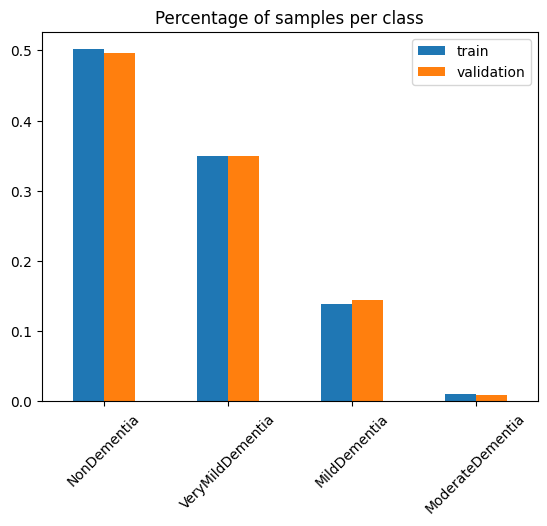

In [9]:
train_labels = np.concatenate([y for _, y in tqdm(train_ds)], axis=0)
val_labels = np.concatenate([y for _, y in tqdm(val_ds)], axis=0)
train_labels = [train_ds.class_names[idx] for idx in train_labels]
val_labels = [val_ds.class_names[idx] for idx in val_labels]

vis_ratio = True # if we want to plot the num of samples or the ratio of each class
vis_title = 'Percentage of samples per class' if vis_ratio else 'Number of samples per class'
df_cnt = pd.concat([pd.Series(train_labels).value_counts(normalize=vis_ratio), pd.Series(val_labels).value_counts(normalize=vis_ratio)], axis=1)
df_cnt.plot(kind='bar', title=vis_title, rot=45)
plt.legend(['train', 'validation'])

# Feature Engineering

Because we are working with categorical and noncontinuous data, we want to convert our model into one-hot encodings. One-hot encodings are a way for the model to understand that we're looking at categorial instead of continuous data. Transforming features so that they'll be more understandable is called feature engineering. Learn more about feature engineering [here](https://developers.google.com/machine-learning/crash-course/representation/feature-engineering).

In [10]:
def one_hot_label(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label



 The function changes data representation in an "easier" way:  converts the label into a one-hot encoded tensor (one-hot representation with a depth of NUM_CLASSES) using TensorFlow's tf.one_hot function, and returns the original image along with its one-hot encoded label. Many deep learning models can operate only on numeric variables for the algorythm efficiency [citation 2]. For categorical variables for which no ordinal relationship exists, as these, the integer encoding is not enough. One hot encoding  converts categorical data to numbers before fitting the model: a new binary variable (column) is added to the dataset for each unique categorical value in the variable (the presence or absence of a "1" in a column indicates the class of the input sample) and the original categorical variable is removed from the dataset ; this avoids introducing ordinal relationships between labels because they are treated as distinct and unrelated;    here this works well since target only has 4 possible values  [SLIDE PROF ?]. One more reason to apply this function is that many loss functions, such as categorical cross-entropy [citation 3]  expect the target labels to be in one-hot encoded format. 







In [11]:
train_ds = train_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)

The following cell makes calling images from our dataset more efficient.

In [12]:
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Deciding a Metric

The most conventional metric to use is probably accuracy. Accuracy, however, cannot be used for imbalanced datasets. Let's check how many images are in each class for our training data.

Our dataset is not balanced, so we cannot use accuracy as our metric. For this tutorial, we will be using ROC AUC. Intuitively, ROC AUC gives a score, with higher scores closer to 1 indicating that the different classes can be distinguishable for the model. A lower score closer indicates that the the model cannot distinguish between different classes. A score of 0.5 indicates that the ordering the images is pretty much random. Learn more about ROC AUC [here](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc).

In [13]:
NUM_IMAGES = []

for label in class_names:
    dir_name = "C:/Users/Utente/Documents/UNIVERSITA_ANNO_5/DEEP_LEARNING/GROUP_PROJECT/Deep-Learning-project/.vscode/Deep-Learning-project-1/archive/Dataset/" + label[:-2] + 'ed'
    NUM_IMAGES.append(len([name for name in os.listdir(dir_name)]))

NUM_IMAGES

[896, 64, 3200, 2241]

In [14]:

def labels_fromPrefetch(test_ds):
    #  Function to extract labels from a Prefetch Dataset 
    # Get y_true labels
    test_ds_it=test_ds.as_numpy_iterator() #Numpy iterator
    true_labels = []  # Lista per le etichette reali

    for batch in test_ds_it:
        # Assumiamo che ogni batch contenga etichette reali e previste
        true_batch,true_batch_labels = batch  # Sostituisci con la chiave corretta
        # Aggiungere le etichette del batch alle liste
        true_labels.extend(true_batch_labels)


    # Confusion matrix
    y_true_onehot = np.vstack(true_labels)
    y_true=np.argmax(y_true_onehot,axis=1)
    return y_true

# Build the ML Model

We'll be using the same architecture for our model as my [Pneumonia Classification NB](https://www.kaggle.com/amyjang/tensorflow-pneumonia-classification-on-x-rays#4.-Build-the-CNN). Using `tf.keras`, we can easily build up the layers of our CNN.

In [15]:

def observations_fromPrefetch(train_ds):
    iterator = iter(train_ds)
    all_tensors=[]
    while True:
        try:
            batch_x, batch_y = iterator.get_next()
            all_tensors.append((batch_x))
        except tf.errors.OutOfRangeError:
            # End of the dataset
            break
    return all_tensors

# Now  all_tensors contains all tensors from your Prefetch Dataset

DATA AUGMENTATION FOR BALANCING CLASSES INSPIRING TO THE PAPER A Deep Siamese Convolution Neural Network for Multi-Class Classification of Alzheimer Disease  (Chiara 6).
In neuroimaging, a large number of scans related to AD patient’s availability are a major issue
because few hundreds of image samples are available. It is a common thing for a deep learning model
to provide more effective results on more data. In medical research, due to privacy concerns, the access
to large data is a big problem [47], especially, the classification of cancer and AD are problematic due to
lack of availability of data. The small imbalanced dataset creates overfitting problems during training
of the model which affects the model efficiency. To overcome this issue, we need more data to enhance
the effective accuracy in our proposed model. We used the augmentation technique to create 10 more
images on each available MRI image [48]. In Table 3, data augmentation is described for the parameters
used for augmentation.


Define layers for data augmenatation inside the model

In [16]:
RandomZoom_layer1=(tf.keras.layers.RandomZoom(
    height_factor=(0.1, 0.3),
    width_factor=(0.1, 0.3),
    fill_mode="constant",
    seed=2023
))

RandomWidth_layer1=tf.keras.layers.RandomWidth(
    (-0.2,0.2), interpolation='bilinear', seed=2023) 

RandomHeight_layer1=tf.keras.layers.RandomHeight(
    (-0.2,0.2), interpolation='bilinear', seed=2023) 

RandomRotation_layer1=tf.keras.layers.RandomRotation(
    (-0.2,0.2),
    fill_mode='reflect',
    interpolation='bilinear',
    seed=2023)

RandomRotation_layer2=tf.keras.layers.RandomRotation(
    (-0.2,0.2),
    fill_mode='constant',
    interpolation='bilinear', fill_value=0.0,
    seed=2023)


RandomFlip_layer1=tf.keras.layers.RandomFlip(
    mode="horizontal_and_vertical", seed=2023)


RandomTranslation_layer1=tf.keras.layers.RandomTranslation(
    (-0.2,0.2),
     (-0.2,0.2),
    fill_mode='reflect',
    interpolation='bilinear',
    seed=2023)

RandomTranslation_layer2=tf.keras.layers.RandomTranslation(
    (-0.2,0.2),
     (-0.2,0.2),
    fill_mode='constant',
    interpolation='bilinear',
    seed=2023,fill_value=0.0)

RandomCrop_layer1=tf.keras.layers.RandomCrop(
    120,120, seed=2023)

RandomBrightness_layer1=tf.keras.layers.RandomBrightness(
    0.2, seed=2023)

RandomContrast_layer1=tf.keras.layers.RandomContrast(
    0.2 , seed=2023)
input_layer= tf.keras.Input(shape=(*IMAGE_SIZE, 3))

In [17]:
# DATA AUGMENTATION FOR BALANCING CLASSES
#data_augmentation = tf.keras.Sequential(
 #   [tf.keras.layers.RandomZoom(height_factor=(0.1,0.3), width_factor=(0.1,0.3), fill_mode="constant", seed=2023),
 #   ] RandomWidth, RandomHeight, RandomRotation, RandomZoom (RandomFlip, RandomTranslation ?? class GaussianNoise: Apply additive zero-centered Gaussian noise?? )  https://www.tensorflow.org/api_docs/python/tf/keras/layers
#)
#Class - 1: Mild Demented (896 images)
#Class - 2: Moderate Demented (64 images)
#Class - 3: Non Demented (3200 images)
#Class - 4: Very Mild Demented (2240 images)
#EXTRACT LABELS
labels_train=labels_fromPrefetch(train_ds)   #1d array of dimension (4095)       
number_of0=np.count_nonzero(labels_train==0)  #568= Class 1 : Mild Demented--> 3,6 (=4) data aug
number_of1=np.count_nonzero(labels_train==1)  #41= Class  2: Moderate Demented (64 images)--> 50 data aug
number_of2=np.count_nonzero(labels_train==2)  #2053= Class 3: Non Demented (3200 images)--> 0 data aug
number_of3=np.count_nonzero(labels_train==3)  #1433 Class= 4: Very Mild Demented (2240 images)--> 1,43 (=1) data aug


# EXTRACT OBSERVATIONS 
tensors_train=observations_fromPrefetch(train_ds)  #list of 103 4D tensorflows tensors (40,128,128,3): 

list_of_arrays = [tensor.numpy() for tensor in tensors_train]  #list of 103 4D arrays  (40,128,128,3)
s=list_of_arrays[0].shape  # (40,128,128,3)

images_tot = [np.reshape((tensor), (-1, 128, 128, 3)) for tensor in list_of_arrays]  # 4D array (4095,128,128,3) 
images_tot = list(np.concatenate(images_tot, axis=0))  # list of 4095 3d arrays

example=images_tot[0]   #ndarray (128,128,3); all values in 3rd dimension are the same --> example[i,j,1]=example[i,j,2]=example[i,j,3]

augmented_images = []
augmented_labels = []
for i in range(len(images_tot)): #len is 4095, first dimensions
    image = images_tot[i]   #nd array (128,128,3)
    label = labels_train[i]

    # Apply data augmentation selectively based on the class label
    if label == 0: #568  Class 1 : Mild Demented--> 2053/568= 3,6 (=4) data aug
        augmented_image = RandomRotation_layer1(image)  #tensor 
        augmented_image2= RandomTranslation_layer1(image)
        augmented_image3=RandomZoom_layer1(image)                                    
        augmented_images_conc = tf.keras.layers.Concatenate(axis=0)([image, augmented_image, augmented_image2, augmented_image3])            
    if label == 1: #41 Class  2: Moderate Demented --> 2053/41= 50 data aug
       augmented_image_list = [RandomRotation_layer1(image) for _ in range(10)]  #list of  50 tensors
       augmented_images_conc1= tf.concat([image] + augmented_image_list, axis=0)

       augmented_image2_list = [RandomTranslation_layer1(image) for _ in range(10)]
       augmented_images_conc2 = tf.concat([image] + augmented_image2_list, axis=0)
       #for augmented_image in augmented_image2_list:
    
       augmented_image3_list = [RandomZoom_layer1(image)  for _ in range(10)]
       #for augmented_image in augmented_image3_list:
       augmented_images_conc3 = tf.concat([image] + augmented_image3_list, axis=0)

       augmented_image4_list = [RandomFlip_layer1(image)  for _ in range(10)]
       #for augmented_image in augmented_image4_list:
       augmented_images_conc4 = tf.concat([image] + augmented_image4_list, axis=0)
       
       augmented_image5_list = [RandomBrightness_layer1(image)  for _ in range(10)] ### I DON'T KNOW IF BRIGHTNESS WORKS!
       #for augmented_image in augmented_image5_list:
       augmented_image_conc5 = tf.concat([image] + augmented_image5_list, axis=0)
       
       augmented_images_conc=tf.concat([augmented_images_conc1, augmented_images_conc2, augmented_images_conc3,augmented_images_conc4,augmented_image_conc5], axis=0)
       # ADD IMAGE!!
    if label == 2: #2053 Class 3: Non Demented --> 2053/2053=1 data aug
       augmented_image=image
       augmented_images_conc=augmented_image
        #augmented_images_conc =augmented_image
    if label == 3:  #1433 Class 4: Very Mild Demented --> 2053/1433 = 1,43 (=2) data aug
        augmented_image=RandomRotation_layer1(image)
        augmented_images_conc = tf.keras.layers.Concatenate(axis=0)([image,augmented_image]) 

    #Target Shape of tensor
    target_shape = (128, 128, 3)

    # Calculate the number of tensors to be created
    num_tensors = augmented_images_conc.shape[0] // target_shape[0]

    # Reshape the tensor into multiple tensors of shape (128, 128, 3)
    augmented_images_resh = tf.split(augmented_images_conc, num_tensors, axis=0)

    #augmented_images_resh = tf.keras.layers.Reshape((128,128,3))(augmented_images_conc)

    #augmented_images_resh= tf.keras.layers.Reshape((-1, 128, 128, 3))(augmented_images_conc)# Reshape the tensor into multiple tensors of shape (128, 128, 3)
    for el in augmented_images_resh:
       augmented_images.append(el)
    for i in range(len(augmented_images_resh)):
       augmented_labels.append(label)


#rotation_range:

"""Descrizione: Intervallo di gradi per le rotazioni casuali delle immagini.
Tipo: Float o Int.
width_shift_range:

Descrizione: Intervallo per traslazioni casuali lungo l'asse orizzontale.
Tipo: Float o Int.
height_shift_range:

Descrizione: Intervallo per traslazioni casuali lungo l'asse verticale.
Tipo: Float o Int.
shear_range:

Descrizione: Intensità della trasformazione di shear (taglio).
Tipo: Float.
zoom_range:

Descrizione: Intervallo di zoom casuale.
Tipo: Float o Tuple di Float.
horizontal_flip:

Descrizione: Booleano. Esegue o meno il flip orizzontale casuale delle immagini.
vertical_flip:

Descrizione: Booleano. Esegue o meno il flip verticale casuale delle immagini.
brightness_range:

Descrizione: Intervallo per la variazione casuale della luminosità delle immagini.
Tipo: Tuple di float o None.
channel_shift_range:

Descrizione: Intensità della trasformazione di shift dei canali.
Tipo: Float.
rescale:

Descrizione: Fattore di ridimensionamento. Moltiplica il valore dei pixel per questo fattore.
preprocessing_function: """

"Descrizione: Intervallo di gradi per le rotazioni casuali delle immagini.\nTipo: Float o Int.\nwidth_shift_range:\n\nDescrizione: Intervallo per traslazioni casuali lungo l'asse orizzontale.\nTipo: Float o Int.\nheight_shift_range:\n\nDescrizione: Intervallo per traslazioni casuali lungo l'asse verticale.\nTipo: Float o Int.\nshear_range:\n\nDescrizione: Intensità della trasformazione di shear (taglio).\nTipo: Float.\nzoom_range:\n\nDescrizione: Intervallo di zoom casuale.\nTipo: Float o Tuple di Float.\nhorizontal_flip:\n\nDescrizione: Booleano. Esegue o meno il flip orizzontale casuale delle immagini.\nvertical_flip:\n\nDescrizione: Booleano. Esegue o meno il flip verticale casuale delle immagini.\nbrightness_range:\n\nDescrizione: Intervallo per la variazione casuale della luminosità delle immagini.\nTipo: Tuple di float o None.\nchannel_shift_range:\n\nDescrizione: Intensità della trasformazione di shift dei canali.\nTipo: Float.\nrescale:\n\nDescrizione: Fattore di ridimensioname

In [18]:
number_of02=augmented_labels.count(0)  #568= Class 1 : Mild Demented-->  2272 Mild Demented
number_of12=augmented_labels.count(1)  #41= Class  2: Moderate Demented (64 images)-->2255 Moderate Demented
number_of22=augmented_labels.count(2)  #2053= Class 3: Non Demented (3200 images)--> 2053  Non Demented
number_of32=augmented_labels.count(3)  #1433 Class= 4: Very Mild Demented (2240 images)--> 2866 Very Mild Demented


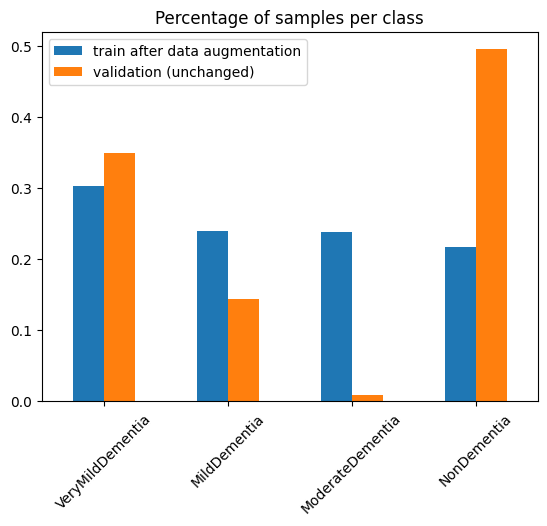

In [25]:
train_labels_after=augmented_labels
#nuova_lista = [5 if elemento == 1 else elemento for elemento in lista]
train_labels_after_names=['MildDementia' if el==0 else 'ModerateDementia' if el==1 else 'NonDementia'  if el==2 else 'VeryMildDementia'   for el in train_labels_after]
vis_ratio = True # if we want to plot the num of samples or the ratio of each class
vis_title = 'Percentage of samples per class' if vis_ratio else 'Number of samples per class'
df_cnt = pd.concat([pd.Series(train_labels_after_names).value_counts(normalize=vis_ratio), pd.Series(val_labels).value_counts(normalize=vis_ratio)], axis=1)
df_cnt.plot(kind='bar', title=vis_title, rot=45)
plt.legend(['train after data augmentation', 'validation (unchanged)'])

In [15]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

In [16]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [17]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(*IMAGE_SIZE, 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    return model

In [18]:
with strategy.scope():
    model = build_model()
    plot_model(model, show_shapes=True)
    METRICS = [tf.keras.metrics.AUC(name='auc')]
    model.summary()

    
    model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS
    )

# Training the Model

To more efficiently train our model. We will be using callbacks to adjust our learning rate and to stop our model once it converges.

The [learning rate](https://developers.google.com/machine-learning/glossary#learning-rate) is a very important hyperparameter in the model. Having a LR that is too high will prevent the model from converging. Having a LR that is too slow will make the process too long. Stopping our model early is one mechanism that prevents overfitting.

In [21]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0*0.1**(epoch/s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 30)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)


# Save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved.
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alzheimer_model.h5",
                                                    save_best_only=True)  

# Model weights are saved at the end of every epoch, if it's the best seen
# so far.
#save_best_only=True   #  keep the model that has achieved the "best performance" so far, or whether to save the model at the end of every epoch regardless of performance.



early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)  # VALIDATION LOSS


#stops training if a monitored metric (in this case, validation loss) does not improve after a certain number of epochs (patience).
# patience=  Number of epochs with no improvement after which training will be stopped.
# restore_best_weights=True --> Whether to restore model weights from the epoch with the best value of the monitored quantity. If False, the model weights obtained at the last step of training are used. An epoch will be restored regardless of the performance relative to the baseline. If no epoch improves on baseline, training will run for patience epochs and restore weights from the best epoch in that set



For example then: 
model.load_weights(checkpoint_filepath) # The model weights (that are considered the best) are loaded into the  model.

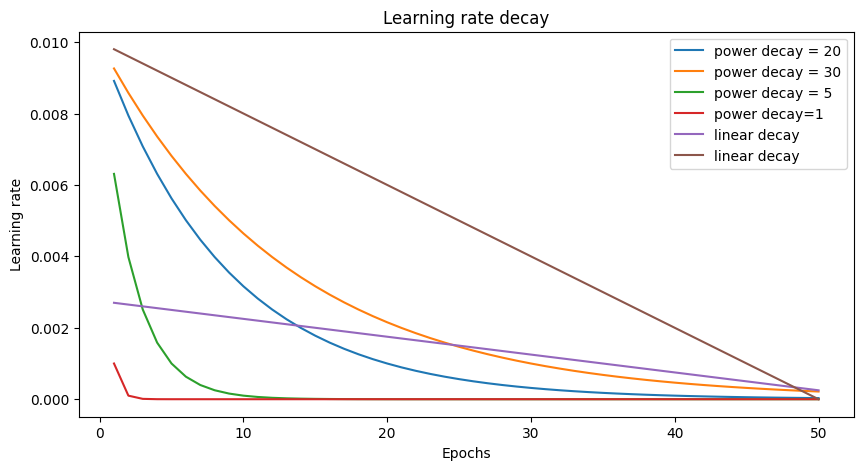

In [38]:
# Plot some learning rate decays and try different ones
s=20
lr0=0.01
s2=100

epochs=np.linspace(1,50,50)
lr_epochs=lr0* 0.1**(epochs / 20)
lr_epochs2=lr0*0.1**(epochs/30)
lr_epochs3=lr0* 0.1**(epochs / 5)
lr_epochs4=lr0*0.1**(epochs)
lr_epochs5=lr0*0.005*(55-epochs)
lr_epochs6=lr0*0.02*(50-epochs)

plt.figure(figsize=(10,5))
plt.plot(epochs, lr_epochs,label="power decay = 20")
plt.plot(epochs, lr_epochs2,label="power decay = 30")
plt.plot(epochs, lr_epochs3,label="power decay = 5")
plt.plot(epochs, lr_epochs4,label="power decay=1")
plt.plot(epochs, lr_epochs5,label="linear decay")
plt.plot(epochs, lr_epochs6,label="linear decay")

plt.title("Learning rate decay")
plt.xlabel("Epochs")
plt.ylabel("Learning rate")
plt.legend()

# comment on CHOICE OF LEARNING RATES

We have plotted different time decays for learning rate, assuming for example 50 epochs, to see how it decreases with epochs.
The parametres from the original code 


Let's fit our model!

In [23]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
    epochs=EPOCHS
)

#consider SHUFFLE:   
# NON è CROSS VALIDATION: DA PROVARE!

Epoch 1/50


103/103 [==============================] - ETA: 0s - loss: 1.1494 - auc: 0.7697

c:\Users\Utente\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


103/103 [==============================] - 129s 1s/step - loss: 1.1494 - auc: 0.7697 - val_loss: 1.0988 - val_auc: 0.7598 - lr: 0.0100
Epoch 2/50
103/103 [==============================] - 103s 995ms/step - loss: 0.9658 - auc: 0.8168 - val_loss: 1.2400 - val_auc: 0.6375 - lr: 0.0093
Epoch 3/50
103/103 [==============================] - 107s 1s/step - loss: 0.9527 - auc: 0.8206 - val_loss: 1.7639 - val_auc: 0.7958 - lr: 0.0086
Epoch 4/50
103/103 [==============================] - 94s 916ms/step - loss: 0.9455 - auc: 0.8258 - val_loss: 16.0307 - val_auc: 0.6675 - lr: 0.0079
Epoch 5/50
103/103 [==============================] - 100s 971ms/step - loss: 0.9234 - auc: 0.8336 - val_loss: 0.9727 - val_auc: 0.8193 - lr: 0.0074
Epoch 6/50
103/103 [==============================] - 98s 955ms/step - loss: 0.9287 - auc: 0.8323 - val_loss: 0.9123 - val_auc: 0.8447 - lr: 0.0068
Epoch 7/50
103/103 [==============================] - 102s 991ms/step - loss: 0.9124 - auc: 0.8379 - val_loss: 1.2658 - val_

# Visualize Model Metrics

Let's graph the ROC AUC metric and loss after each epoch for the training and validation data. Although we didn't use a random seed for our notebook, the results may slightly vary, generally the scores for the validataion data is similar, if not better, than the training dataset.

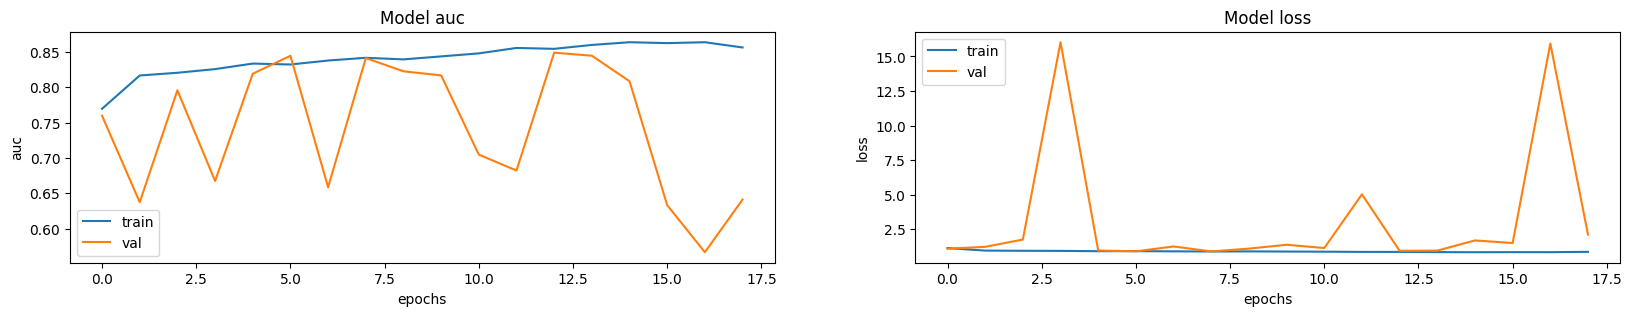

In [24]:
fig, ax = plt.subplots(ncols=2,figsize=(20, 3))

h=history.history
mett=h.keys()
for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])


I  ALSO ADDED AUC PLOT 
TO ADD : BALANCED ACCURACY ?

# Evaluate the Model

Although we used the validatation dataset to continually evaluate the model, we also have a separate testing dataset. Let's prepare the testing dataset.

In [55]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "C:/Users/Utente/Documents/UNIVERSITA_ANNO_5/DEEP_LEARNING/GROUP_PROJECT/Deep-Learning-project/.vscode/Deep-Learning-project-1/archive/Dataset/test",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

test_ds = test_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 1282 files belonging to 6 classes.


In [ ]:
# TO EVALUATE TOGETHER
#ts_length = len(test_df)
#test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
#test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_ds, verbose= 1)
valid_score = model.evaluate(val_ds, verbose= 1)
test_score = model.evaluate(test_ds, verbose= 1)



print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])


33/33 [==============================] - 9s 253ms/step - loss: 0.4203 - auc: 0.9712
Train Loss:  0.037956174463033676
Train Accuracy:  0.9998902082443237
--------------------
Validation Loss:  0.38499557971954346
Validation Accuracy:  0.9762882590293884
--------------------
Test Loss:  0.42034441232681274
Test Accuracy:  0.971248984336853


Print balanced accuracy ( IF WE BALANCE CLASSES NOT NECESSARY!)

In [ ]:
train_labels=labels_fromPrefetch(train_ds)
train_predictions = model.predict(train_ds)
train_pred_labels = np.argmax(train_predictions, axis=1) # Convert predictions to class labels
balanced_acc_train = balanced_accuracy_score(train_labels, train_pred_labels)

print("Balanced Accuracy Training Set:", balanced_acc_train)


val_labels=labels_fromPrefetch(val_ds)
val_predictions = model.predict(val_ds)
val_pred_labels = np.argmax(val_predictions, axis=1) # Convert predictions to class labels
balanced_acc_val = balanced_accuracy_score(val_labels, val_pred_labels)

print("Balanced Accuracy Validation Set:", balanced_acc_val)


test_labels=labels_fromPrefetch(val_ds)
preds = model.predict(test_ds)
y_pred = np.argmax(preds, axis=1) # Convert predictions to class labels
balanced_acc = balanced_accuracy_score(test_labels, y_pred)

print(y_pred)
print("Balanced Accuracy Test Set:", balanced_acc)

DEFINE A FUNCTION TO PLOT CONFUSION MATRIX

In [ ]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
	'''
	This function plot confusion matrix method from sklearn package.
	'''

	plt.figure(figsize= (10, 10))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()

	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)

	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')

	else:
		print('Confusion Matrix, Without Normalization')

	print(cm)

	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')
	




33/33 [==============================] - 8s 233ms/step
[0 3 3 ... 2 2 2]


NameError: name 'test_gen' is not defined

Print confusion matrix and some metrics

In [57]:
# Get y_true labels
y_true=labels_fromPrefetch(test_ds)
preds = model.predict(test_ds)
y_pred = np.argmax(preds, axis=1)
cm= sklearn.metrics.confusion_matrix(y_true, y_pred)

import itertools
classes=class_names
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix')

# Classification report
print(classification_report(y_true, y_pred, target_names= classes))

NameError: name 'preds' is not defined